In [1]:
import tensorflow as tf
tf.version.VERSION

'2.8.0'

In [2]:
# set Keras backend to Tensorflow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [3]:
# import
import keras
from keras.models import load_model
from keras_adabound import AdaBound
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

In [4]:
# make saving directory
saveDir = "./cifar10/semiAda/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [5]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [6]:
from keras.utils import np_utils
# prerequisite
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [8]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [9]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [10]:
from keras_adabound import AdaBound

# optimization and compile
def compileModel(model, lr=1e-3, decay=0.1):
    opt = AdaBound(learning_rate=lr, final_lr=decay)

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
   
    return model

In [11]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [12]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [13]:
# get the CNN model
model = getModel()

In [14]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

In [15]:
# run training on the initial dataset

model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)


Epoch 1: val_loss improved from inf to 1.87356, saving model to ./cifar10/semiAda\Cifar10_.01-2.03-1.87.hdf5

Epoch 2: val_loss improved from 1.87356 to 1.54285, saving model to ./cifar10/semiAda\Cifar10_.02-1.72-1.54.hdf5

Epoch 3: val_loss improved from 1.54285 to 1.44643, saving model to ./cifar10/semiAda\Cifar10_.03-1.56-1.45.hdf5

Epoch 4: val_loss improved from 1.44643 to 1.38960, saving model to ./cifar10/semiAda\Cifar10_.04-1.45-1.39.hdf5

Epoch 5: val_loss improved from 1.38960 to 1.31964, saving model to ./cifar10/semiAda\Cifar10_.05-1.37-1.32.hdf5

Epoch 6: val_loss improved from 1.31964 to 1.25381, saving model to ./cifar10/semiAda\Cifar10_.06-1.28-1.25.hdf5

Epoch 7: val_loss did not improve from 1.25381

Epoch 8: val_loss improved from 1.25381 to 1.20120, saving model to ./cifar10/semiAda\Cifar10_.08-1.15-1.20.hdf5

Epoch 9: val_loss improved from 1.20120 to 1.20027, saving model to ./cifar10/semiAda\Cifar10_.09-1.09-1.20.hdf5

Epoch 10: val_loss improved from 1.20027 to

In [16]:
# use the pre-trained model, with 65% accuracy on test data
# model = getNewestModel()
model.load_weights("./cifar10/semiAda/Cifar10_.15-0.74-1.07.hdf5")

In [17]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

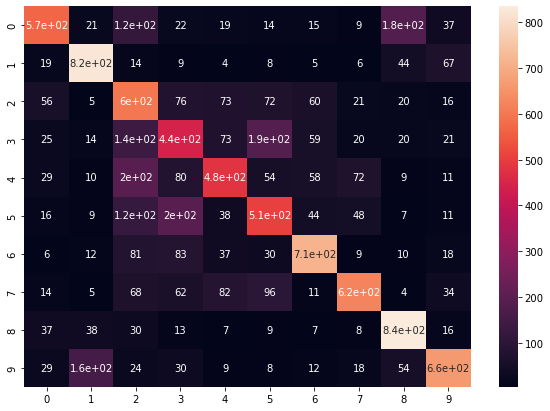

              precision    recall  f1-score   support

           0       0.71      0.57      0.63      1000
           1       0.75      0.82      0.79      1000
           2       0.43      0.60      0.50      1000
           3       0.44      0.44      0.44      1000
           4       0.58      0.48      0.53      1000
           5       0.51      0.51      0.51      1000
           6       0.72      0.71      0.72      1000
           7       0.75      0.62      0.68      1000
           8       0.70      0.83      0.76      1000
           9       0.74      0.66      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000

Accuracy: 0.6255


In [18]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [19]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])


[1.0689727067947388, 0.6255000233650208]


In [20]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [21]:
# concatenate initial training data with high probability inference, removing them from remaining data

from keras import utils as np_utils


def concatHighProbData(proba, remainX, remainY, xTrain, yTrain, bound=0.99):
    hp = getHighProb(proba, bound)
    print("number of data with probability higher than {0}: {1}".format(bound,len(hp)))
    
    nhp = np.array(hp)
    xAdd = remainX[nhp[:,0]]
    yAdd = np.array([nhp[:,1]]).T
    yAdd = keras.utils.np_utils.to_categorical(yAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added: {0}\ny shape to be added: {1}".format(xAdd.shape, yAdd.shape))
    
    NewXTrain = np.vstack((xTrain, xAdd))
    NewYTrain = np.vstack((yTrain, yAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nhp[:,0], axis=0)
    remainY2 = np.delete(remainY, nhp[:,0], axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
    
    yEval = [[yActual[i],yAdd[i]] for i in range(len(yAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [22]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [23]:
# get new training data
# proba = model.predict_proba(remainXTrain, verbose=0)
proba=model.predict(remainXTrain,verbose=0)
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatHighProbData(proba, 
                                                                          remainXTrain, 
                                                                          remainYTrain, 
                                                                          x_train1, 
                                                                          y_train1, 
                                                                          0.9999)
errPred = getError(yEval)

number of data with probability higher than 0.9999: 243
x shape to be added: (243, 32, 32, 3)
y shape to be added: (243, 10)
new training data:
	x: (10243, 32, 32, 3)
	y: (10243, 10)
remaining data:
	x: (39757, 32, 32, 3)
	y: (39757, 10)


In [24]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)


Epoch 1: val_loss improved from inf to 1.11069, saving model to ./cifar10/semiAda\Cifar10_.01-0.68-1.11.hdf5

Epoch 2: val_loss did not improve from 1.11069
Epoch 2: early stopping


In [25]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

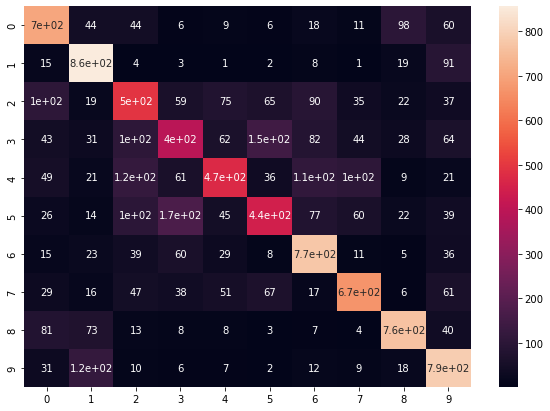

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1000
           1       0.70      0.86      0.77      1000
           2       0.51      0.49      0.50      1000
           3       0.49      0.40      0.44      1000
           4       0.62      0.47      0.53      1000
           5       0.57      0.45      0.50      1000
           6       0.65      0.77      0.70      1000
           7       0.71      0.67      0.69      1000
           8       0.77      0.76      0.77      1000
           9       0.64      0.79      0.70      1000

    accuracy                           0.64     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.63      0.64      0.63     10000

Accuracy: 0.6355


In [26]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [27]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.110687255859375, 0.6355000138282776]


In [28]:
for i in range(30):
    #proba = model.predict_proba(remainXTrain, verbose=0)
    proba=model.predict(remainXTrain,verbose=0)
    remainXTrain, remainYTrain, x_train2, y_train2, yEval = concatHighProbData(proba, 
                                                                               remainXTrain, 
                                                                               remainYTrain, 
                                                                               x_train2, 
                                                                               y_train2, 
                                                                               0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with probability higher than 0.9999: 471
x shape to be added: (471, 32, 32, 3)
y shape to be added: (471, 10)
new training data:
	x: (10714, 32, 32, 3)
	y: (10714, 10)
remaining data:
	x: (39286, 32, 32, 3)
	y: (39286, 10)

Epoch 1: val_loss improved from inf to 1.05938, saving model to ./cifar10/semiAda\Cifar10_.01-0.72-1.06.hdf5

Epoch 2: val_loss did not improve from 1.05938
Epoch 2: early stopping

After Iter: 0
	Loss and Acc: [1.0593839883804321, 0.6434999704360962]

number of data with probability higher than 0.9999: 208
x shape to be added: (208, 32, 32, 3)
y shape to be added: (208, 10)
new training data:
	x: (10922, 32, 32, 3)
	y: (10922, 10)
remaining data:
	x: (39078, 32, 32, 3)
	y: (39078, 10)

Epoch 1: val_loss improved from inf to 1.09787, saving model to ./cifar10/semiAda\Cifar10_.01-0.64-1.10.hdf5

Epoch 2: val_loss did not improve from 1.09787
Epoch 2: early stopping

After Iter: 1
	Loss and Acc: [1.097872018814087, 0.640999972820282]

number of data wit


Epoch 1: val_loss improved from inf to 1.50836, saving model to ./cifar10/semiAda\Cifar10_.01-0.14-1.51.hdf5

Epoch 2: val_loss improved from 1.50836 to 1.41290, saving model to ./cifar10/semiAda\Cifar10_.02-0.13-1.41.hdf5

Epoch 3: val_loss did not improve from 1.41290
Epoch 3: early stopping

After Iter: 15
	Loss and Acc: [1.412901520729065, 0.6735000014305115]

number of data with probability higher than 0.9999: 456
x shape to be added: (456, 32, 32, 3)
y shape to be added: (456, 10)
new training data:
	x: (22392, 32, 32, 3)
	y: (22392, 10)
remaining data:
	x: (27608, 32, 32, 3)
	y: (27608, 10)

Epoch 1: val_loss improved from inf to 1.48592, saving model to ./cifar10/semiAda\Cifar10_.01-0.13-1.49.hdf5

Epoch 2: val_loss did not improve from 1.48592
Epoch 2: early stopping

After Iter: 16
	Loss and Acc: [1.4859156608581543, 0.6697999835014343]

number of data with probability higher than 0.9999: 472
x shape to be added: (472, 32, 32, 3)
y shape to be added: (472, 10)
new training d